In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time

# Directory and version specifications

In [48]:
from datetime import datetime

MODEL_TIMESTAMP = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")

DATA_PATH = 'data/'

CLASSIFICATION_REPORTS_PATH = 'classification_reports/'
SAMPLE_GRAPH_RESULTS_PATH  = 'sample_graph_result/'
TREE_PATH = 'tree/'

# Resolución de imágenes
resolution = 300

# Download and Store Data

In [11]:
# for index in range(0,22):
#     index_str = str(index)

#     print(index_str)
    
#     if len(index_str) == 1:
#         index_str = '0' + index_str

#     print(index_str)

#     url = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_20{}.csv".format(index_str)
#     print(url)

#     FILE_NAME = "atp_matches_20{}.csv".format(index_str)

#     df = pd.read_csv(url, index_col=0, parse_dates=[0])
#     df.to_csv(DATA_PATH + FILE_NAME)

# # data_frame = pd.read_csv(DATA_PATH + FILE_NAME)

# Load Data

In [12]:
atp = pd.DataFrame()

years_index_20_22 = range(0,22)

for index in years_index_20_22:
    index_str = str(index)

    if len(index_str) == 1:
        index_str = '0' + index_str

    FILE_NAME = "atp_matches_20{}.csv".format(index_str)

    data_frame_iter = pd.read_csv(DATA_PATH + FILE_NAME)
    atp = pd.concat([atp, data_frame_iter])

pd.set_option('display.max_columns', None)
atp

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2000-301,Auckland,Hard,32,A,20000110,1,103163,1.0,NaN,Tommy Haas,R,188.0,GER,21.771389,101543,NaN,NaN,Jeff Tarango,L,180.0,USA,31.137577,7-5 4-6 7-5,3,R32,108.0,18.0,4.0,96.0,49.0,39.0,28.0,17.0,3.0,5.0,7.0,8.0,106.0,55.0,39.0,29.0,17.0,4.0,7.0,11.0,1612.0,63.0,595.0
1,2000-301,Auckland,Hard,32,A,20000110,2,102607,NaN,Q,Juan Balcells,R,190.0,ESP,24.558522,102644,NaN,NaN,Franco Squillari,L,183.0,ARG,24.386037,7-5 7-5,3,R32,85.0,5.0,3.0,76.0,52.0,39.0,13.0,12.0,5.0,6.0,5.0,10.0,74.0,32.0,25.0,18.0,12.0,3.0,6.0,211.0,157.0,49.0,723.0
2,2000-301,Auckland,Hard,32,A,20000110,3,103252,NaN,NaN,Alberto Martin,R,175.0,ESP,21.390828,102238,NaN,NaN,Alberto Berasategui,R,173.0,ESP,26.535250,6-3 6-1,3,R32,56.0,0.0,0.0,55.0,35.0,25.0,12.0,8.0,1.0,1.0,0.0,6.0,56.0,33.0,20.0,7.0,8.0,7.0,11.0,48.0,726.0,59.0,649.0
3,2000-301,Auckland,Hard,32,A,20000110,4,103507,7.0,NaN,Juan Carlos Ferrero,R,183.0,ESP,19.909651,103819,NaN,NaN,Roger Federer,R,185.0,SUI,18.422998,6-4 6-4,3,R32,68.0,5.0,1.0,53.0,28.0,26.0,15.0,10.0,0.0,0.0,11.0,2.0,70.0,43.0,29.0,14.0,10.0,6.0,8.0,45.0,768.0,61.0,616.0
4,2000-301,Auckland,Hard,32,A,20000110,5,102103,NaN,Q,Michael Sell,R,180.0,USA,27.381246,102765,4.0,NaN,Nicolas Escude,R,185.0,FRA,23.770021,0-6 7-6(7) 6-1,3,R32,115.0,1.0,2.0,98.0,66.0,39.0,14.0,13.0,6.0,11.0,8.0,8.0,92.0,46.0,34.0,18.0,12.0,5.0,9.0,167.0,219.0,34.0,873.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2722,2021-M-DC-2021-WG2-M-THA-DEN-01,Davis Cup WG2 R1: THA vs DEN,Hard,4,D,20210917,4,200416,NaN,NaN,August Holmgren,R,NaN,DEN,23.394935,106397,NaN,NaN,Wishaya Trongcharoenchaikul,R,NaN,THA,26.433949,6-4 6-4,3,RR,90.0,3.0,3.0,52.0,29.0,22.0,16.0,10.0,0.0,1.0,8.0,2.0,79.0,45.0,30.0,14.0,10.0,10.0,13.0,905.0,16.0,767.0,27.0
2723,2021-M-DC-2021-WG2-M-THA-DEN-01,Davis Cup WG2 R1: THA vs DEN,Hard,4,D,20210917,5,208937,NaN,NaN,Kasidit Samrej,R,NaN,THA,20.629706,134087,NaN,NaN,Johannes Ingildsen,R,NaN,DEN,24.202601,7-5 6-3,3,RR,88.0,6.0,6.0,58.0,28.0,21.0,13.0,11.0,3.0,7.0,5.0,8.0,76.0,43.0,24.0,13.0,10.0,5.0,11.0,1136.0,8.0,1546.0,2.0
2724,2021-M-DC-2021-WG2-M-TUR-LAT-01,Davis Cup WG2 R1: TUR vs LAT,Hard,4,D,20210918,1,123795,NaN,NaN,Altug Celikbilek,U,NaN,TUR,25.015743,207669,NaN,NaN,Robert Strombachs,U,NaN,GER,21.995893,7-6(4) 6-4,3,RR,124.0,6.0,8.0,80.0,34.0,25.0,23.0,11.0,6.0,8.0,3.0,5.0,97.0,50.0,34.0,20.0,11.0,6.0,9.0,170.0,427.0,671.0,38.0
2725,2021-M-DC-2021-WG2-M-TUR-LAT-01,Davis Cup WG2 R1: TUR vs LAT,Hard,4,D,20210918,2,117356,NaN,NaN,Cem Ilkel,R,185.0,TUR,26.064339,105208,NaN,NaN,Ernests Gulbis,R,190.0,LAT,33.037645,6-4 6-1,3,RR,65.0,2.0,2.0,41.0,27.0,23.0,7.0,9.0,0.0,1.0,1.0,5.0,45.0,21.0,16.0,7.0,8.0,2.0,7.0,176.0,408.0,196.0,359.0


In [13]:
# COLUMNS_TO_REMOVE = ["tourney_id", "tourney_name", "tourney_date",
#                      "match_num",
#                      "winner_id", "loser_id",
#                      "winner_seed", "loser_seed",
#                      "winner_name", "loser_name",
#                      "winner_ioc", "loser_loc",
#                      "winner_rank", "loser_rank",
#                      "winner_rank_points", "loser_rank_points",
#                      "round"]

# Clean Dataset

In [14]:
# Vamos a eliminar las variables que son identificadores, nombres etc
# Incluimos en el drop las siguientes variables que tienen muchos registros NaN
# quitaremos las columna de score
df_regression = atp


COLUMNS_TO_REMOVE = ['tourney_id', 'tourney_name', 'tourney_date',
                     'winner_name', 'loser_name',
                     'winner_entry', 'loser_entry',
                     'winner_seed', 'loser_seed',
                     'winner_id', 'loser_id',
                     'score']

df_regression = df_regression.drop(COLUMNS_TO_REMOVE, axis = 1) 
df_regression = df_regression.dropna()
df_regression = df_regression.drop_duplicates()

# Crearemos dos formulas para calculos del ganador y el perdedor para evitar la correlación de estas variables, tambien haremos un drop de estas variables.
df_regression['w_calculation'] = df_regression['w_svpt'] + df_regression['w_1stIn'] + df_regression['w_1stWon'] + df_regression['w_2ndWon'] + df_regression['w_SvGms']
df_regression['l_calculation'] = df_regression['l_svpt'] + df_regression['l_1stIn'] + df_regression['l_1stWon'] + df_regression['l_2ndWon'] + df_regression['l_SvGms']

df_regression = df_regression.drop(['w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms'], axis = 1) 

df_regression = df_regression._get_numeric_data() #drop non-numeric cols

# Split Data

In [15]:
from sklearn.model_selection import train_test_split

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

#X = scale(X)
#y = scale(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Para Clasificación de:

- Tipo de pista: `l_1stWon`, `winner_ht`, `loser_ht`, `w_1stWon`, `l_1stWon`
- Nivel de torneo: `Draw_size`, `winner_rank_points`, `loser_rank_points`, `loser_rank`, `winner_rank`

# Ensembles

Lo primero será buscar el Árbol de regresión que más accuracy nos dé mediante cross-validation para usarlo en el proceso de Bagging.

In [16]:
from sklearn.tree import DecisionTreeRegressor

best_params = {'criterion': 'absolute_error',
               'max_depth': 7,
               'max_features': None,
               'min_weight_fraction_leaf': 0.0,
               'splitter': 'best'}

decision_tree = DecisionTreeRegressor()
decision_tree.set_params(**best_params)

DecisionTreeRegressor(criterion='absolute_error', max_depth=7)

## Bagging

Bootstrap Aggregation o Bagging es una técnica que permite utilizar el resampling Bootstrap para consturir ensembles y poder utilizar varios conjuntos de datos para cada uno de los modelos pertenecientes a la arquitectura ensemble diseñada.

En el caso de la regresión, esta técnica permite calcular la media de las prediccciones de cada uno de los modelos entrenados mediante Bootstrap para obtener un resultado final que dependa de todos los modelos.

[Referencia](https://machinelearningmastery.com/bagging-ensemble-with-python/)

### Definition

In [50]:
from sklearn.ensemble import BaggingRegressor

MODEL_NAME = 'bagging'

num_models = 10
bagging = BaggingRegressor(decision_tree,
                           n_estimators = num_models,
                           max_samples  = 0.5,
                           max_features = 0.5)

### Training

In [18]:
start = time.time()

bagging_regressor = bagging.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)

print(f"Done in {ellapsed_time} (s)")

Done in 104.86 (s)


### Metrics

In [19]:
from sklearn.metrics import mean_squared_error

y_pred = bagging_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

score = bagging_regressor.score(X_test, y_test)
print("R-squared:", score) 

MSE:  226.3675216262976
RMSE:  113.1837608131488
R-squared: 0.8584766670069934


### Graphic Results

FileNotFoundError: [Errno 2] No such file or directory: 'sample_graph_result/adaboost/adaboost_2022-05-02-11:13:29.png'

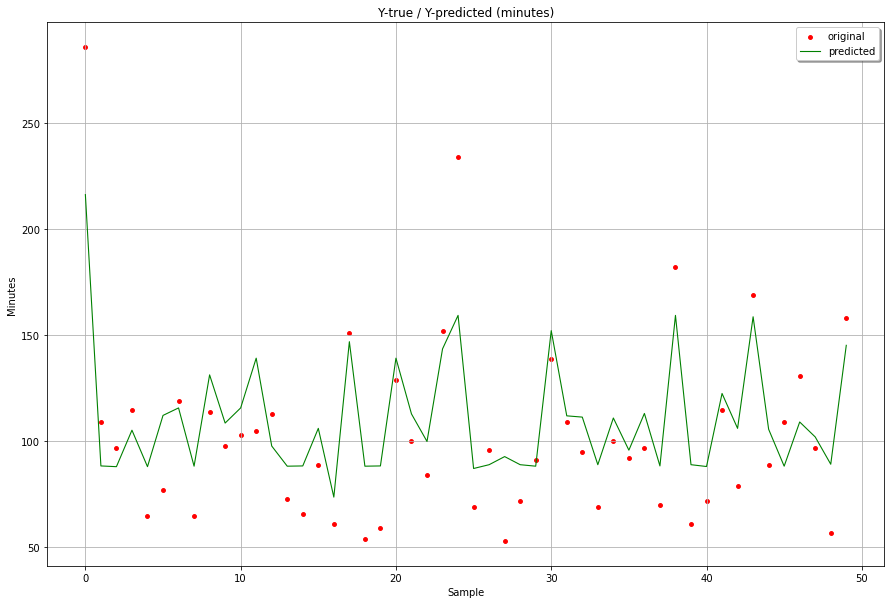

In [77]:
n_samples = range(len(y_test[:50]))

# plt.plot(x, y, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="green")
plt.figure(figsize=(15,10))  # set plot size (denoted in inches)

plt.scatter(n_samples, y_test[:50], s = 15, color = 'red', label = "original")
plt.plot(n_samples, y_pred[:50], linewidth = 1.1, color = 'green', label = "predicted")

plt.title("Y-true / Y-predicted (minutes)")
plt.xlabel('Sample')
plt.ylabel('Minutes')

plt.legend(loc='best',fancybox = True, shadow = True)

GRAPH_PATH = f"{SAMPLE_GRAPH_RESULTS_PATH}{MODEL_NAME}/"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()


# Save Confusion Matrix image
GRAPH_PATH = f"{SAMPLE_GRAPH_RESULTS_PATH}{MODEL_NAME}/"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

## Boosting

### ADABoost

AdaBoost utiliza múltiples weak learners (árboles de decisión de un nivel) que son agregados secuencialmente al conjunto de modelos, con el objetivo de que cada uno de estos árboles minimice el error producido por el anterior modelo.

Esto se consigue asignando una serie de pesos (ponderación) a cada una de las muestras que estén clasificadas erróneamente (clasificación) o que tengan un error alto (regresión).

[Referencia](https://machinelearningmastery.com/adaboost-ensemble-in-python/)

#### Definition

In [74]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

MODEL_NAME = 'adaboost'

num_models = 10

ada_boost_regresor = AdaBoostRegressor()

#### Training

Bayesian Optimization

In [ ]:
# from sklearn.model_selection import cross_val_score

# ada_boost_regresor = AdaBoostRegressor()

# search_grid = {'n_estimators': [500,1000,2000],
#                'learning_rate': [.001,0.01,.1],
#                'random_state': [1]
#               }

# search = GridSearchCV(estimator= ada_boost_regresor,
#                       param_grid = search_grid,
#                       scoring = 'neg_mean_squared_error',
#                       n_jobs = 1,
#                       cv = 5)

# search.fit(X,y)
# search.best_params_

TypeError: __init__() missing 1 required positional argument: 'param_grid'

In [87]:
start = time.time()

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV

# grid = dict()
# grid['n_estimators'] = [10, 50, 100, 500]
# grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

# # define the evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define the grid search procedure
# grid_search = GridSearchCV(estimator=ada_boost_regresor, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# # execute the grid search
# grid_result = grid_search.fit(X, y)
# # summarize the best score and configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# # summarize all scores that were evaluated
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

    
    
    

ada_boost_regresor.fit(X, y)

end = time.time()

ellapsed_time = round(end - start, 2)

print(f"Done in {ellapsed_time} (s)")

Done in 6.73 (s)


#### Metrics

In [67]:
y_pred = ada_boost_regresor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

score = ada_boost_regresor.score(X_test, y_test)
print("R-squared:", score)

MSE:  472.8887223859315
RMSE:  236.44436119296574
R-squared: 0.7043533999663366


#### Graphic Results

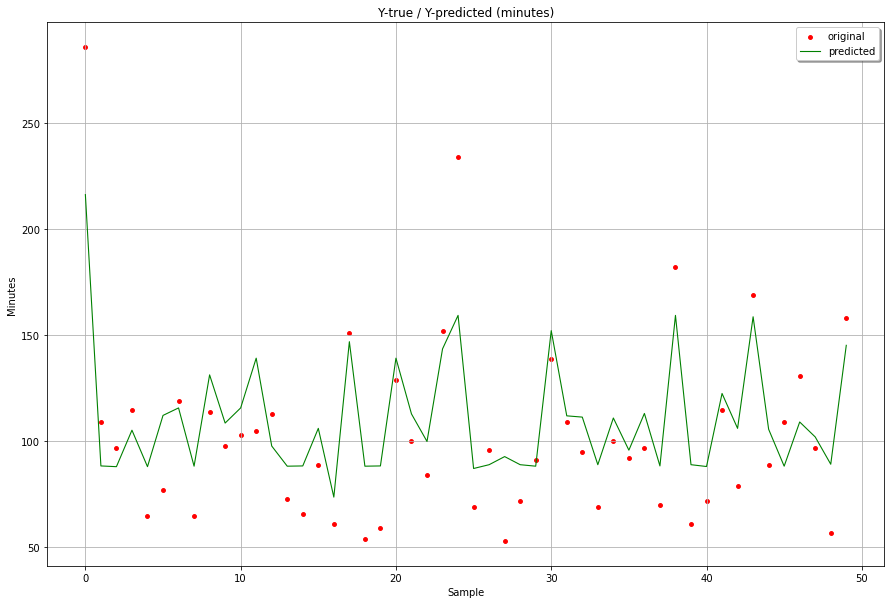

In [76]:
n_samples = range(len(y_test[:50]))

# plt.plot(x, y, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="green")
plt.figure(figsize=(15,10))  # set plot size (denoted in inches)

plt.scatter(n_samples, y_test[:50], s = 15, color = 'red', label = "original")
plt.plot(n_samples, y_pred[:50], linewidth = 1.1, color = 'green', label = "predicted")

plt.title("Y-true / Y-predicted (minutes)")
plt.xlabel('Sample')
plt.ylabel('Minutes')

plt.legend(loc='best',fancybox = True, shadow = True)

# Save Confusion Matrix image
GRAPH_PATH = f"{SAMPLE_GRAPH_RESULTS_PATH}boosting/{MODEL_NAME}/"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

### Gradient Boosting Regressor

Minimiza los residuos del modelo previo en cada iteración mediante descenso por gradiente.

#### Definition

In [93]:
from sklearn.ensemble import GradientBoostingRegressor

MODEL_NAME = 'gradientboost'

learning_rate = 0.8
num_models = 10

boosting = GradientBoostingRegressor(criterion = best_params['criterion'],
                                     max_depth = best_params['max_depth'],
                                     n_estimators  = num_models,
                                     learning_rate = learning_rate)

#### Training

In [90]:
start = time.time()

boosting_regressor = boosting.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)

print(f"Done in {ellapsed_time} (s)")

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1854: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  warnings.warn(


KeyboardInterrupt: 

#### Metrics

In [ ]:
y_pred = boosting_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

score = boosting_regressor.score(X_test, y_test)
print("R-squared:", score) 

#### Graphic Results

In [ ]:
n_samples = range(len(y_test[:50]))

# plt.plot(x, y, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="green")
plt.figure(figsize=(15,10))  # set plot size (denoted in inches)

plt.scatter(n_samples, y_test[:50], s = 15, color = 'red', label = "original")
plt.plot(n_samples, y_pred[:50], linewidth = 1.1, color = 'green', label = "predicted")

plt.title("Y-true / Y-predicted (minutes)")
plt.xlabel('Sample')
plt.ylabel('Minutes')

plt.legend(loc='best',fancybox = True, shadow = True)

# Save Confusion Matrix image
GRAPH_PATH = f"{SAMPLE_GRAPH_RESULTS_PATH}boosting/{MODEL_NAME}/"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

## Stacking

### Definition

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import StackingRegressor

# define the base models
base_models = list()
base_models.append(('knn', KNeighborsClassifier(n_neighbors=3)))
base_models.append(('cart', DecisionTreeRegressor()))
base_models.append(('svm', SVC()))


# define meta learner model
meta_learner = LogisticRegression()

# define the stacking ensemble
stacking = StackingRegressor(estimators = base_models,
                              final_estimator = meta_learner,
                              cv = 5)

### Training

In [96]:
start = time.time()

stacking_regressor = stacking.fit(X_train, y_train)

end = time.time()

ellapsed_time = round(end - start, 2)

print(f"Done in {ellapsed_time} (s)")

ValueError: The estimator KNeighborsClassifier should be a regressor.

### Metrics

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = stacking_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

# score = stacking_regressor.score(X_test, y_test)
print("R-squared:", score)

### Graphic Results

In [ ]:
n_samples = range(len(y_test[:50]))

# plt.plot(x, y, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="green")
plt.figure(figsize=(15,10))  # set plot size (denoted in inches)

plt.scatter(n_samples, y_test[:50], s = 15, color = 'red', label = "original")
plt.plot(n_samples, y_pred[:50], linewidth = 1.1, color = 'green', label = "predicted")

plt.title("Y-true / Y-predicted (minutes)")
plt.xlabel('Sample')
plt.ylabel('Minutes')

plt.legend(loc='best',fancybox = True, shadow = True)

# Save Confusion Matrix image
GRAPH_PATH = f"{SAMPLE_GRAPH_RESULTS_PATH}boosting/{MODEL_NAME}/"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

# Conclusiones

Como hemos podido comprobar, es posible aplicar distintas técnicas de ensembles a un problema, concretamente:
- Bagging
- Boosting
    - AdaBoost
    - Gradient Boosting Regressor
- Stacking

Después de haber probado las distintas arquitecturas, los mejores resultados se han obtenido en MEJORMODELO con un RMSE de RMSEMEJOR con respecto a RMSE1 de MODELO1, RMSE2 MODELO2 y RMSE3 del MODELO3 respectivamente.
    

Por motivos de tiempo de ejecución no se han podido testar distintas combinaciones de modelos a la hora de construir los ensembles, por lo que se propone como trabajos futuros la implementación y el estudio de distintas arquitecturas que permitan minimizar aún más el error producido en la regresión y, por ende, mejorar la precisión de los resultados.